<a href="https://colab.research.google.com/github/chivy-debug/Detect_SQL-Injection-XSS_Using_ML-DL/blob/main/Detect_XSS_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import thư viện
import pandas as pd
import re
import numpy as np
from joblib import dump, load
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report, \
    accuracy_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Tải dataset
df = pd.read_csv("/content/XSS_dataset.csv")

In [2]:
# Hàm rút trích đặc trưng từ payload XSS
def extract_xss_features(payload):
    features = {}

    if not isinstance(payload, str):
        # Xử lý trường hợp payload không phải string
        for feature_name in [
            'length', 'script_tags', 'event_handlers', 'javascript_protocols', 'eval_usage',
            'dom_functions', 'html_entities', 'special_chars', 'iframe_usage', 'encoded_chars',
            'data_protocols', 'attribute_delimiters', 'suspicious_functions', 'nested_tags',
            'whitespace_count', 'uppercase_count', 'decimal_encoding', 'hex_encoding',
            'unicode_encoding', 'base64_patterns', 'img_tags', 'style_attributes',
            'svg_elements', 'meta_refresh', 'url_parameters', 'comment_tags',
            'malformed_tags', 'css_expressions', 'line_breaks', 'escape_sequences'
        ]:
            features[feature_name] = 0
        return features

    payload = payload.lower()  # Chuyển về chữ thường

    # 1. Độ dài của payload
    features['length'] = len(payload)

    # 2. Số thẻ script
    features['script_tags'] = len(re.findall(r'<script.*?>|</script>', payload, re.IGNORECASE))

    # 3. Số event handlers
    event_handlers = [
        'onload', 'onclick', 'onmouseover', 'onmouseout', 'onkeypress', 'onchange',
        'onfocus', 'onmouseup', 'onmousedown', 'ondblclick', 'onsubmit', 'onunload',
        'onerror', 'onkeydown', 'onkeyup', 'onblur', 'onscroll', 'onselect'
    ]
    features['event_handlers'] = sum(payload.count(handler) for handler in event_handlers)

    # 4. JavaScript protocols
    features['javascript_protocols'] = len(re.findall(r'javascript:|vbscript:|data:', payload))

    # 5. Sử dụng eval và các hàm tương tự
    eval_functions = ['eval(', 'setinterval(', 'settimeout(', 'function(', 'execscript(']
    features['eval_usage'] = sum(payload.count(func) for func in eval_functions)

    # 6. DOM manipulation functions
    dom_functions = [
        'document.', 'window.', 'document.write', 'document.cookie', 'innerHTML',
        'outerHTML', 'documentElement', 'createElement'
    ]
    features['dom_functions'] = sum(payload.count(func) for func in dom_functions)

    # 7. HTML entities
    features['html_entities'] = len(re.findall(r'&[#\w]+;', payload))

    # 8. Ký tự đặc biệt
    special_chars = ['<', '>', '"', "'", ';', '=', '(', ')', '{', '}', '[', ']']
    features['special_chars'] = sum(payload.count(char) for char in special_chars)

    # 9. Sử dụng iframe
    features['iframe_usage'] = len(re.findall(r'<iframe.*?>|</iframe>', payload, re.IGNORECASE))

    # 10. Mã hóa ký tự
    features['encoded_chars'] = len(re.findall(r'%[0-9a-fA-F]{2}', payload))

    # 11. Data protocols
    features['data_protocols'] = len(re.findall(r'data:.*,', payload))

    # 12. Dấu phân cách thuộc tính
    features['attribute_delimiters'] = payload.count('"') + payload.count("'")

    # 13. Các hàm đáng ngờ
    suspicious_functions = ['alert(', 'prompt(', 'confirm(', 'fetch(', 'xhr.', 'ajax']
    features['suspicious_functions'] = sum(payload.count(func) for func in suspicious_functions)

    # 14. Thẻ lồng nhau
    features['nested_tags'] = len(re.findall(r'<[^>]*<', payload))

    # 15. Số lượng khoảng trắng
    features['whitespace_count'] = len(re.findall(r'\s', payload))

    # 16. Số ký tự viết hoa
    features['uppercase_count'] = sum(1 for c in payload if c.isupper())

    # 17. Mã hóa thập phân
    features['decimal_encoding'] = len(re.findall(r'&#\d+;', payload))

    # 18. Mã hóa hex
    features['hex_encoding'] = len(re.findall(r'&#x[0-9a-fA-F]+;', payload))

    # 19. Mã hóa Unicode
    features['unicode_encoding'] = len(re.findall(r'\\u[0-9a-fA-F]{4}', payload))

    # 20. Mẫu Base64
    features['base64_patterns'] = len(re.findall(r'base64,', payload))

    # 21. Thẻ img
    features['img_tags'] = len(re.findall(r'<img.*?>', payload, re.IGNORECASE))

    # 22. Thuộc tính style
    features['style_attributes'] = len(re.findall(r'style\s*=', payload))

    # 23. Phần tử SVG
    features['svg_elements'] = len(re.findall(r'<svg.*?>|</svg>', payload, re.IGNORECASE))

    # 24. Meta refresh
    features['meta_refresh'] = len(re.findall(r'<meta.*?refresh.*?>', payload, re.IGNORECASE))

    # 25. Tham số URL
    features['url_parameters'] = len(re.findall(r'\?.*=.*', payload))

    # 26. Comment tags
    features['comment_tags'] = len(re.findall(r'<!--.*?-->|/\*.*?\*/', payload))

    # 27. Malformed tags
    features['malformed_tags'] = len(re.findall(r'<\w+[^>]*[^/]>', payload))

    # 28. CSS expressions
    features['css_expressions'] = len(re.findall(r'expression\s*\(', payload))

    # 29. Line breaks
    features['line_breaks'] = payload.count('\n') + payload.count('\r')

    # 30. Escape sequences
    features['escape_sequences'] = len(re.findall(r'\\[nrtbfv\'"\\]', payload))

    return features


# Trích xuất đặc trưng
features_df = df['Sentence'].apply(extract_xss_features).apply(pd.Series)

# Chuẩn bị dữ liệu đầu vào
X = features_df
y = df['Label']  # Nhãn 1 (xss), 0 (benign)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Chia dữ liệu
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Kiểm tra phân bố nhãn
print(f"Training set distribution: {np.bincount(y_train)}")
print(f"Testing set distribution: {np.bincount(y_test)}")

Training set distribution: [5050 5050]
Testing set distribution: [1263 1262]



--- Random Forest Model Evaluation ---
Accuracy: 0.996
Precision: 0.999
Recall: 0.994
F1-Score: 0.996

Classification Report:
              precision    recall  f1-score   support

           0      0.994     0.999     0.996      1263
           1      0.999     0.994     0.996      1262

    accuracy                          0.996      2525
   macro avg      0.996     0.996     0.996      2525
weighted avg      0.996     0.996     0.996      2525



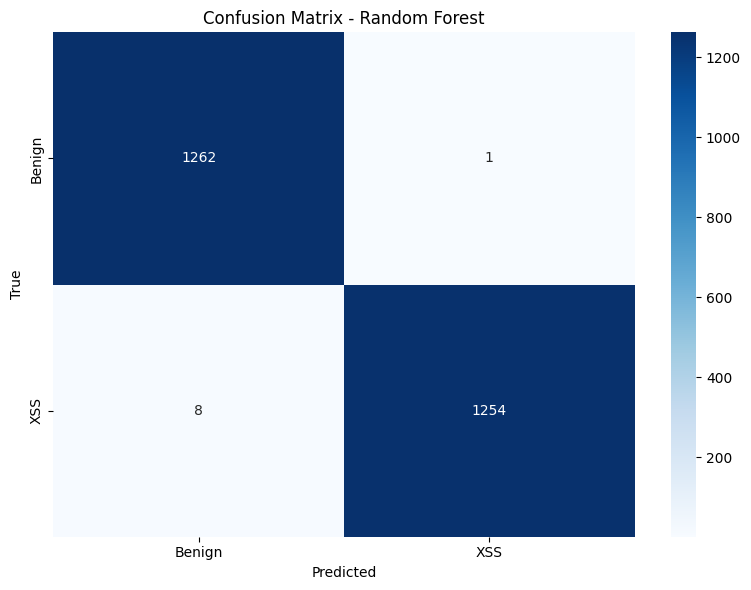

In [3]:
# Random Forest Model
from sklearn.ensemble import RandomForestClassifier

# Huấn luyện mô hình Random Forest
model = RandomForestClassifier(n_estimators=300, random_state=0)
model.fit(X_train, y_train)

# Đánh giá trên tập test
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n--- Random Forest Model Evaluation ---")
print(f'Accuracy: {accuracy:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1-Score: {f1:.3f}')
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'XSS'],
            yticklabels=['Benign', 'XSS'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Random Forest')
plt.tight_layout()
plt.show()


--- XGBoost Model Evaluation ---
Accuracy: 0.997
Precision: 0.999
Recall: 0.994
F1-Score: 0.997

Classification Report:
              precision    recall  f1-score   support

           0      0.994     0.999     0.997      1263
           1      0.999     0.994     0.997      1262

    accuracy                          0.997      2525
   macro avg      0.997     0.997     0.997      2525
weighted avg      0.997     0.997     0.997      2525



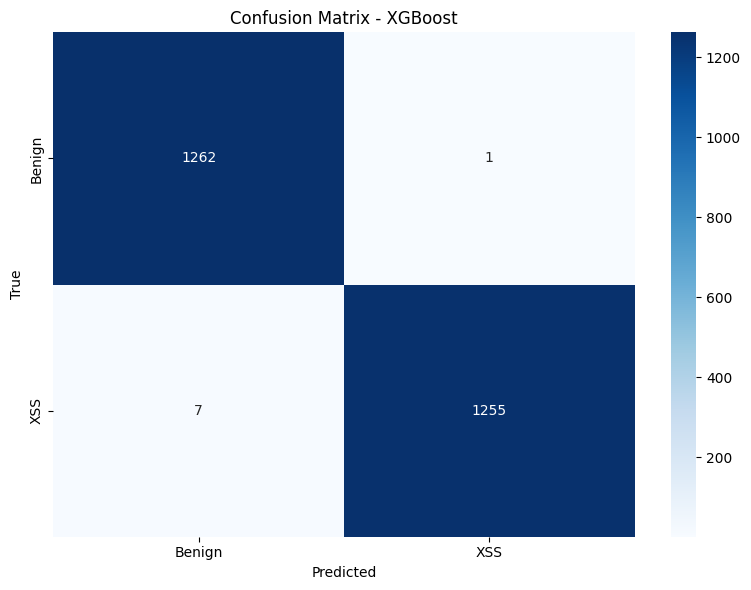

In [4]:
# XGBoost Model
from xgboost import XGBClassifier

# Huấn luyện mô hình XGBoost
model = XGBClassifier(n_estimators=400, random_state=0)
model.fit(X_train, y_train)

# Đánh giá mô hình
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n--- XGBoost Model Evaluation ---")
print(f'Accuracy: {accuracy:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1-Score: {f1:.3f}')
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'XSS'],
            yticklabels=['Benign', 'XSS'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - XGBoost')
plt.tight_layout()
plt.show()


--- KNN Model Evaluation ---
Accuracy: 0.994
Precision: 0.998
Recall: 0.991
F1-Score: 0.994

Classification Report:
              precision    recall  f1-score   support

           0      0.991     0.998     0.994      1263
           1      0.998     0.991     0.994      1262

    accuracy                          0.994      2525
   macro avg      0.994     0.994     0.994      2525
weighted avg      0.994     0.994     0.994      2525



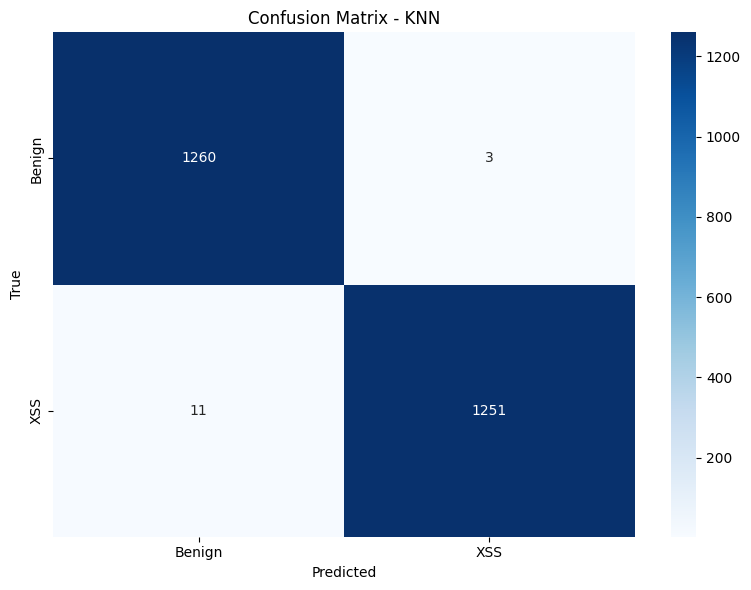

In [5]:
# KNN Model
from sklearn.neighbors import KNeighborsClassifier

# Chuẩn hóa dữ liệu (quan trọng cho KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Khởi tạo và huấn luyện mô hình KNN
k = 5  # Số lượng neighbors
model = KNeighborsClassifier(n_neighbors=k, weights='uniform', algorithm='auto')
model.fit(X_train_scaled, y_train)

# Đánh giá mô hình
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n--- KNN Model Evaluation ---")
print(f'Accuracy: {accuracy:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1-Score: {f1:.3f}')
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'XSS'],
            yticklabels=['Benign', 'XSS'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - KNN')
plt.tight_layout()
plt.show()



--- Decision Tree Model Evaluation ---
Accuracy: 0.994
Precision: 0.997
Recall: 0.991
F1-Score: 0.994

Classification Report:
              precision    recall  f1-score   support

           0      0.991     0.997     0.994      1263
           1      0.997     0.991     0.994      1262

    accuracy                          0.994      2525
   macro avg      0.994     0.994     0.994      2525
weighted avg      0.994     0.994     0.994      2525



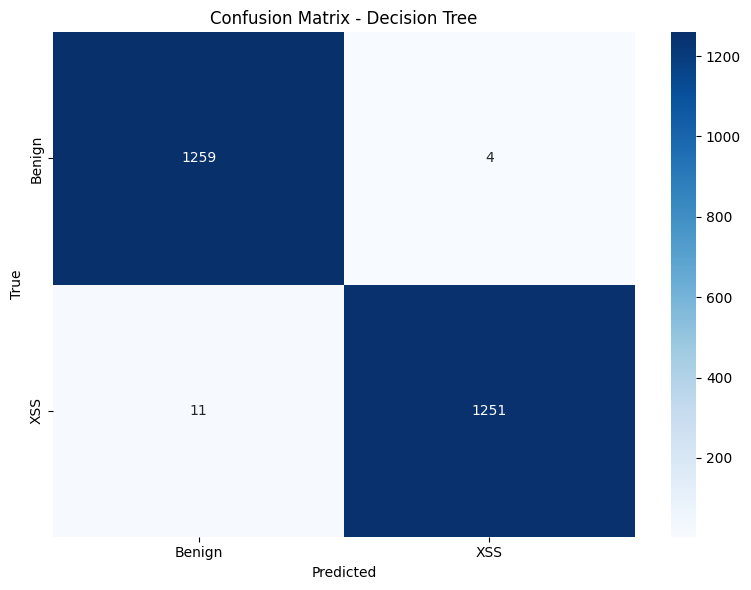

In [6]:
# Decision Tree Model
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Khởi tạo và huấn luyện mô hình Decision Tree
model = DecisionTreeClassifier(random_state=0, max_depth=10)  # max_depth để tránh overfitting
model.fit(X_train, y_train)

# Đánh giá mô hình
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n--- Decision Tree Model Evaluation ---")
print(f'Accuracy: {accuracy:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1-Score: {f1:.3f}')
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'XSS'],
            yticklabels=['Benign', 'XSS'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Decision Tree')
plt.tight_layout()
plt.show()

Bắt đầu huấn luyện mô hình SVM...
Hoàn thành huấn luyện mô hình SVM

--- SVM Model Evaluation ---
Accuracy: 0.994
Precision: 0.999
Recall: 0.988
F1-Score: 0.994

Classification Report:
              precision    recall  f1-score   support

           0      0.988     0.999     0.994      1263
           1      0.999     0.988     0.994      1262

    accuracy                          0.994      2525
   macro avg      0.994     0.994     0.994      2525
weighted avg      0.994     0.994     0.994      2525



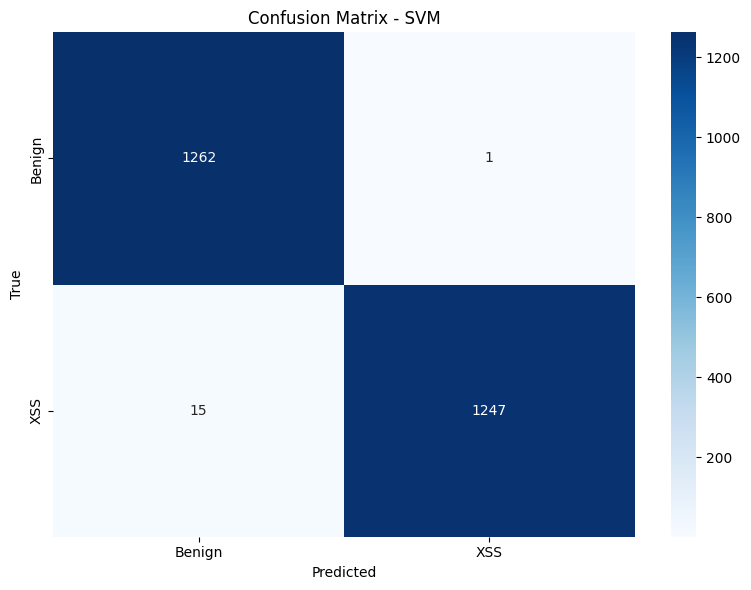

In [7]:
# SVM Model
from sklearn.svm import SVC

# Chuẩn hóa dữ liệu (quan trọng cho SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Huấn luyện mô hình SVM
model = SVC(kernel='linear', random_state=0)
print("Bắt đầu huấn luyện mô hình SVM...")
model.fit(X_train_scaled, y_train)
print("Hoàn thành huấn luyện mô hình SVM")

# Đánh giá mô hình
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n--- SVM Model Evaluation ---")
print(f'Accuracy: {accuracy:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1-Score: {f1:.3f}')
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'XSS'],
            yticklabels=['Benign', 'XSS'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - SVM')
plt.tight_layout()
plt.show()